442 10


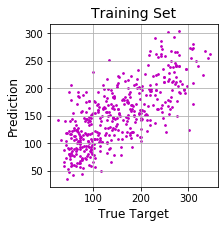

In [122]:
#1,the skeleton implementation of a Gaussian RBF model
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
def gaussian(x, u, sigma):
    return(np.exp(-0.5 * np.linalg.norm(x-u) / sigma))
N, p = X.shape# Numbers of observations and dimensions
print(N, p)
# Space for design matrix
#
M = 20
U = np.zeros((N,M))# Return N*M dimension matrix filled with zeros
# Basis function locations at random
#
C = np.random.randn(M,p)# Return a M*p samples from the "standard normal" distribution
# Basis function range as distance between two random data
#
x1 = X[np.floor(np.random.rand()*N).astype(int),:]
x2 = X[np.floor(np.random.rand()*N).astype(int),:]
sigma = np.linalg.norm(x1-x2)
# Construct the design matrix
#
for i in range(N):
    for j in range(M):
        U[i,j] = gaussian(X[i,:], C[j,:], sigma)
# Pseudo inverse solution for linear part
#
l = np.linalg.inv(U.T @ U) @ U.T @ y
# Predicted values on training data
#
yh = U @ l
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y, yh, c='m', s=3)
ax.grid(True)
ax.set_title("Training Set", fontsize=14)
ax.set_xlabel("True Target", fontsize=12)
ax.set_ylabel("Prediction", fontsize=12)
fig.savefig('fig1')

In [123]:
#2.1, Normalize each features of the input data to have a mean of 0 nad sd of 1
X_normed = (X - X.mean(axis=0)) / X.std(axis=0)
print(X_normed.mean(axis=0))
print(X_normed.std(axis=0))

[-9.54490383e-18 -8.38946810e-17  2.41134413e-17  2.05968977e-17
 -5.92788764e-17 -5.45064245e-17  5.32505161e-17  2.71778578e-16
  2.95138474e-18 -2.02515229e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [124]:
#2.2, Change the sigma to the average of several pairwise distances
x3 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
x4 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
sigma1 = np.linalg.norm(x3-x4)

x5 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
x6 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
sigma2 = np.linalg.norm(x5-x6)

x7 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
x8 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
sigma3 = np.linalg.norm(x7-x8)

x9 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
x10 = X_normed[np.floor(np.random.rand()*N).astype(int),:]
sigma4 = np.linalg.norm(x9-x10)

sigma_new=(sigma1+sigma2+sigma3+sigma4)/4
print(round(sigma,4))
print(round(sigma_new,4))

0.1134
4.8397


In [125]:
#2.3, Using K-means clustering (with K = M) and set the basis function locations to the cluster centres
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=M, random_state=0).fit(X_normed)
print(kmeans.cluster_centers_.shape)

(20, 10)


In [126]:
# 2.4, Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normed, y, test_size=0.3)
print(X_train.shape[0])

309


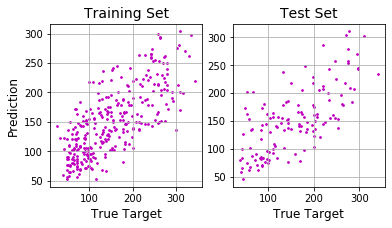

In [127]:
#2.5, Reimplement the RBF model
#train--------
U_train = np.zeros((X_train.shape[0],M))# Return trainsize*M dimension matrix filled with zeros
# Construct the design matrix
#
for i in range(X_train.shape[0]):
    for j in range(M):
        U_train[i,j] = gaussian(X_train[i,:], kmeans.cluster_centers_[j,:], sigma_new)
# Pseudo inverse solution for linear part
#
l_new = np.linalg.inv(U_train.T @ U_train) @ U_train.T @ y_train
# Predicted values on training data
#
yh_train = U_train @ l_new


#test-----------
U_test = np.zeros((X_test.shape[0],M))# Return trainsize*M dimension matrix filled with zeros
# Construct the design matrix
#
for i in range(X_test.shape[0]):
    for j in range(M):
        U_test[i,j] = gaussian(X_test[i,:], kmeans.cluster_centers_[j,:], sigma_new)

# Predicted values on training data
#
yh_test = U_test @ l_new

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(y_train, yh_train, c='m', s=3)
ax[0].grid(True)
ax[0].set_title("Training Set", fontsize=14)
ax[0].set_xlabel("True Target", fontsize=12)
ax[0].set_ylabel("Prediction", fontsize=12)

ax[1].scatter(y_test, yh_test, c='m', s=3)
ax[1].grid(True)
ax[1].set_title("Test Set", fontsize=14)
ax[1].set_xlabel("True Target", fontsize=12)
#ax[1].set_ylabel("Prediction", fontsize=12)

fig.savefig('fig2')

In [42]:
# 3,ten fold cross validation
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(10, shuffle=True, random_state=1)
model=linear_model.LinearRegression()
mses = cross_val_score(model, X_normed, y, scoring="neg_mean_squared_error", cv=kf)
print(mses)

[-3319.69258714 -2727.47718696 -2611.16224586 -3381.09358172
 -3248.22014085 -3146.74309247 -3173.64361407 -3168.59181615
 -2647.96417109 -2749.01079102]


In [128]:
def RBF_model(X_train_,y_train_,X_test_):    
    #train--------
    U_train_ = np.zeros((X_train_.shape[0],M))# Return trainsize*M dimension matrix filled with zeros
    # Construct the design matrix
    #
    for i in range(X_train_.shape[0]):
        for j in range(M):
            U_train_[i,j] = gaussian(X_train_[i,:], kmeans.cluster_centers_[j,:], sigma_new)
    # Pseudo inverse solution for linear part
    #
    l_new_ = np.linalg.inv(U_train_.T @ U_train_) @ U_train_.T @ y_train_
    # Predicted values on training data
    #yh_train = U_train @ l_new


    #test-----------
    U_test_ = np.zeros((X_test_.shape[0],M))# Return trainsize*M dimension matrix filled with zeros
    # Construct the design matrix
    #
    for i in range(X_test_.shape[0]):
        for j in range(M):
            U_test_[i,j] = gaussian(X_test_[i,:], kmeans.cluster_centers_[j,:], sigma_new)

    # Predicted values on training data
    #
    yh_test_ = U_test_ @ l_new_
    return yh_test_

In [129]:
from sklearn.metrics import mean_squared_error
def train_and_validate(D,f, folds):
    fold_mses1 = []
    fold_mses2 = []
    for fold in folds:
        # Train
        size=int(D.shape[0]/10)
        model = linear_model.LinearRegression()
        
        D_test = D[(fold-1)*size:fold*size,:]
        f_test = f[(fold-1)*size:fold*size]

        D_train1 = D[0:(fold-1)*size,:]
        D_train2 = D[fold*size:,:]
        D_train=np.concatenate((D_train1, D_train2), axis=0)
        f_train1 = f[0:(fold-1)*size]
        f_train2 = f[fold*size:]
        f_train=np.concatenate((f_train1, f_train2), axis=0)
        
        model.fit(D_train, f_train)
        # Predict
        fp1 = model.predict(D_test)
        fp2=RBF_model(D_train,f_train,D_test)
        mse1 = mean_squared_error(f_test, fp1)
        mse2 = mean_squared_error(f_test, fp2)
        #rmse = mse**(1/2)
        fold_mses1.append(mse1)
        fold_mses2.append(mse2)
    return(fold_mses1,fold_mses2)
fold_ids = [1,2,3,4,5,6,7,8,9,10]
mses1,mses2 = train_and_validate(X_normed,y, fold_ids)
print(['%.2f' % elem for elem in mses1] )
print(['%.2f' % elem for elem in mses2] )

['2552.96', '2916.32', '3517.61', '2609.62', '3605.83', '2908.94', '3801.59', '2211.73', '4248.14', '1787.24']
['3367.02', '2620.83', '2853.60', '2876.54', '3312.29', '3297.07', '3324.82', '2227.35', '3854.51', '2302.26']


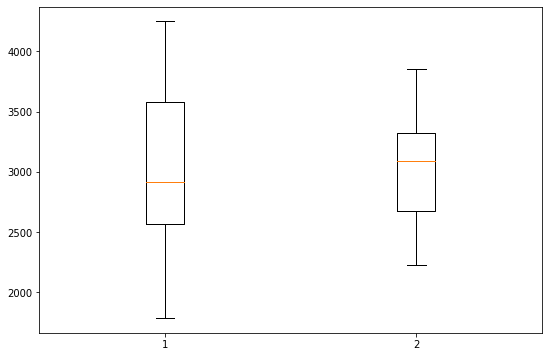

In [130]:
#4, plot the box plot
# Create data
data_to_plot = [mses1, mses2]
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
ax.boxplot(data_to_plot)
# Save the figure
fig.savefig('fig3.png', bbox_inches='tight')

In [115]:
#5,sklearn’s inbuilt RBF model.
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
#X_train, X_test, y_train, y_test
regressor.fit(X_train,y_train)
yh_train_svr = regressor.predict(X_train)
yh_test_svr = regressor.predict(X_test)

C:\Users\shafe_000\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


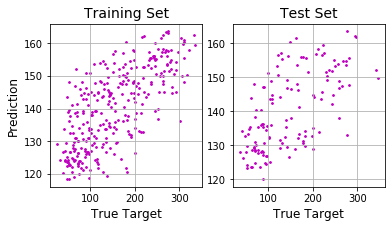

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(y_train, yh_train_svr, c='m', s=3)
ax[0].grid(True)
ax[0].set_title("Training Set", fontsize=14)
ax[0].set_xlabel("True Target", fontsize=12)
ax[0].set_ylabel("Prediction", fontsize=12)

ax[1].scatter(y_test, yh_test_svr, c='m', s=3)
ax[1].grid(True)
ax[1].set_title("Test Set", fontsize=14)
ax[1].set_xlabel("True Target", fontsize=12)
#ax[1].set_ylabel("Prediction", fontsize=12)

fig.savefig('fig4')

In [121]:

print('rbf train mse',round(mean_squared_error(y_train, yh_train),2))
print('rbf test mse',round(mean_squared_error(y_test, yh_test),2))

print('svr train mse',round(mean_squared_error(y_train, yh_train_svr),2))
print('svr test mse',round(mean_squared_error(y_test, yh_test_svr),2))

rbf train mse 2869.96
rbf test mse 3079.05
svr train mse 5085.82
svr test mse 4666.23
